___

> ### Green HPC: An analysis of the domain based on Top500

____

### - Description:

The demand in computing power has never stopped growing
over the years. Today, the performance of the most powerful systems
exceeds the exascale and the number of petascale platforms continues
to grow. Unfortunately, this growth also goes hand in hand with ever-
increasing energy costs, which in turn means a significant carbon foot-
print. In view of the environmental crisis, this paper intents to look at
the often hidden issue of energy consumption of HPC platforms. It is not
easy to access the data of the constructors, we then consider the Top500
as the tip of the iceberg to identify the trends of the whole

### - Contribution:

Our main objective in this work is to identify and clarify the impacts of the HPC
domain from the perspective of energy consumption. The main contributions are
the followin

g:
– Take stock of the empirical laws governing the evolution of HPC computing
systems both from the performance and energy perspect.
ives
– Analyze the most relevant data for developing the performance and energy
efficiency of large-scale computing plat
forms
– Put these analyses into perspective with effects and impacts (life span of the
HPC s
ystems)
– Derive a predictive model for the weight of HPC sector within the horizon
2030the horizon
2030.

In [1]:
# Imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import numpy as np

from typing import List
from scipy.optimize import curve_fit

In [2]:
warnings.filterwarnings('ignore')

# Power : KW
# Rmax/Rpeak : GFlops
# Energy efficiency : Gflops/Watts

In [3]:
# Some useful functions to:
## filter data:
def read_filter_top500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific top500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    file_path = f"./data/top500/TOP500_{y}{m}.xls{'x'*min(1, max(0, y-2019))}"
    df_f = pd.read_excel(
            file_path, 
            header=1 - min(1, max(0, y - 2007))
        )
    # truncating by range
    df_f = df_f.iloc[:range]

    # some data cleaning + scaling (Tflops to Gflops)
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y > 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y > 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000 
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))

    # choosing the fields of interest 
    df_f = df_f[fields]

    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])
    
    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/output_data/TOP500_{y}{m}.csv')
    
    return df_f

def read_filter_green500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific Green500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    df_f = pd.read_excel(f"./data/green500/#green500_{y}_{m}.xlsx", header=0)

    # truncating by range
    df_f = df_f.iloc[:range]

    # homogenising the fields
    if y == 2014 and m == '06':
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
    elif y == 2015:
        df_f['TOP500 Rank'] = df_f['top500_rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
        df_f['Power'] = df_f['total_power']
    elif y == 2016 and m == '06' or (y == 2014 and m == '11'):
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
        df_f['Rank'] = df_f['Green500_Rank']
    elif y == 2016 and m == '11':
        df_f['TOP500 Rank'] = df_f['Rank']
        df_f['Rank'] = df_f['Green500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
    elif y < 2020:
        df_f['G_eff'] = df_f['Power Effeciency [GFlops/Watts]']
    elif y < 2022:
        df_f['G_eff'] = df_f['Power Efficiency [GFlops/Watts]']
    else:
        df_f['G_eff'] = df_f['Energy Efficiency [GFlops/Watts]']
    
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y> 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y >= 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
            df_f['Power'] = df_f['Power (kW)']
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))
    
    # choosing the fields of interest
    df_f = df_f[fields]
    
    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])

    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/output_data/GREEN500_{y}{m}.csv')

    return df_f


## calculate apparitions:
def calc_apparition(l: List, unit: str = 'y'):
    """Calculates the apparition time of an HPC in the top500 list by years/months.
    
    Args:
        l (list): the list of apparition dates.
        unit (str): output unit.
        
    Returns:
        the apparition time in the chosen unit.
    """
    c = 0
    dates = []
    for el in l:
        if el[1] in dates:
            l.remove(el)
            continue
        dates.append(el[1])
        c+=1

    # return the apparition time 
    if unit == 'y':
        return c * 6 / 12

    return c

## calculate other values ...
def exp_funct(x: float, a: float, b: float):
    """Calculates the exp."""
    return a * np.power(np.exp(x), b)

def moore_funct(x: float, df: pd.DataFrame, metric: str = "RMax"):
    """Calculates moore's prediction."""
    return df.iloc[0][metric] * 2 ** (x/4)

def koomey_funct(x: float, df: pd.DataFrame, y: float = 0, metric: str = "G_eff"):
    """Calculates koomey's prediction."""
    return df.iloc[y][metric] * 2 ** ((x-y)/3)


In [4]:
# Our fields of interest.
main_fields = ['Computer', 'Year', 'Country', 'Cores', 'Rank', 'Site', 'RMax', 'RPeak']
main_green_fields = ['Computer', 'Year', 'Country', 'Cores', 'Site', 'Power',
                     'RMax', 'RPeak', 'TOP500 Rank', 'Rank', 'Accelerator/Co-Processor', 'G_eff']
# concatenate all the extracted dataframes into one single one from the year 1993 to 2023.
concat_df = pd.concat(
        [read_filter_top500_data(y, m, range=500, fields=main_fields) 
        for y in range(1994, 2023) for m in ['06', '11']], ignore_index=True
    )

green_concat_df = pd.concat(
        [read_filter_green500_data(y, m, range=100, fields=main_green_fields) 
        for y in range(2014, 2023) for m in ['06', '11']], ignore_index=True
    )

# some info about the concatenated dataframe
concat_df.info()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

In [5]:
# adding a minimum rank column.
tmp_fields = list(main_fields)
tmp_fields.remove('Rank')

concat_df['min_rank'] = concat_df[main_fields].groupby(tmp_fields).transform('min')
green_concat_df['g_min_rank'] = green_concat_df[tmp_fields + ['TOP500 Rank']].groupby(tmp_fields).transform('min')

# visualizing the output
concat_df.tail()


,Computer,Year,Country,Cores,Rank,Site,RMax,RPeak,rank_year,min_rank
28995,"Sugon TC6000, Xeon Gold 5118 12C 2.3GHz, 10G E...",2018,China,97920,496,Telecom Operator (C),1736000.0,7206912.0,2022-11,306
28996,"ThinkSystem Flex SN550, Xeon Gold 6150 18C 2.7...",2018,China,32400,497,Government,1735660.0,2799360.0,2022-11,117
28997,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,498,Internet Service A,1729000.0,3072000.0,2022-11,95
28998,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,499,Internet Service A,1729000.0,3072000.0,2022-11,95
28999,"Inspur SA5212H5, Xeon Platinum 8163 24C 2.5GHz...",2017,China,38400,500,Internet Service A,1729000.0,3072000.0,2022-11,95


Avg shelflife: 1.40 | Max shelflife: 11.50 | Min shelflife: 0.50.  [+/- 0->6 months]


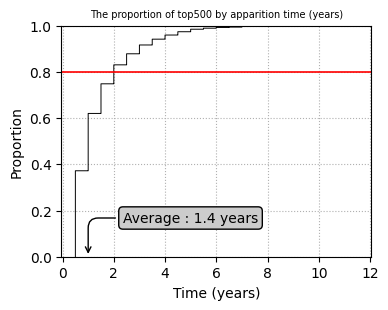

In [6]:
# plotting: The proportion of top500 by apparition time (years)
## plot settings
offset = 50
plt.figure(figsize=(4, 3))
plt.grid(linestyle='dotted')
plt.title('The proportion of top500 by apparition time (years)', fontsize=7)

## data reformatting
g_df = concat_df.copy(deep=True)
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list)

# plotting the data
ax = sns.ecdfplot(data=g_df.reset_index()['rank_year'].apply(calc_apparition), color='black', linewidth=0.7)

# axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Proportion')

# Apparition time [mean, max, min]
minimum, average, maximum = g_df.apply(calc_apparition).min(), g_df.apply(calc_apparition).mean(), g_df.apply(calc_apparition).max()
print(
    "Avg shelflife: {0:.2f} | Max shelflife: {1:.2f} | Min shelflife: {2:.2f}.  [+/- 0->6 months]".format(
        average,
        maximum,
        minimum
        )
    )

# addiung an arrow to point out the average
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

ax.annotate(
        f'Average : {average:.1f} years',
        xy=(1, 0), 
        xytext=(0.5*offset, 0.5*offset), textcoords='offset points',
        bbox=dict(boxstyle="round", fc="0.8"), arrowprops=arrowprops
    )

# highlighting the 80% proportion threshold
plt.axhline(y = 0.8, color = 'r', linewidth=1.2)


Text(59.426826714409714, 0.5, 'Performance (GFlops)')

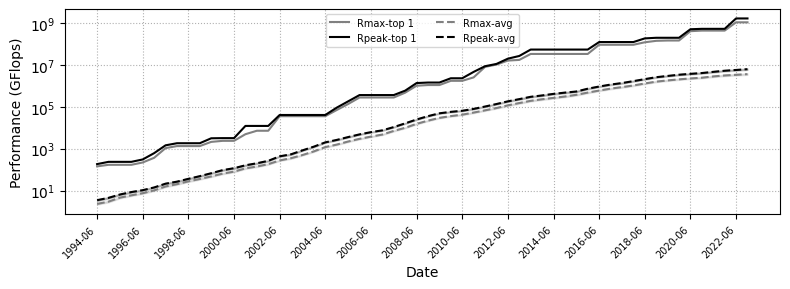

In [7]:
# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
plt.figure(figsize=(8, 3))
plt.yscale('log')
plt.grid(linestyle='dotted')

## mean & max df
log_df_max = concat_df[concat_df.Rank == 1]
log_df_mean = concat_df[concat_df.min_rank <= 500]

## The top1 plots
ax = sns.lineplot(data=log_df_max, x='rank_year', y='RMax', label='Rmax-top 1', markers=True, color='grey')
sns.lineplot(data=log_df_max, x='rank_year', y='RPeak', label='Rpeak-top 1', markers=True, color='black')

## The mean plots
sns.lineplot(data=log_df_mean, x='rank_year', y='RMax', label='Rmax-avg', markers=True, color='grey', linestyle='--')
sns.lineplot(data=log_df_mean, x='rank_year', y='RPeak', label='Rpeak-avg', markers=True, color='black', linestyle='--')

## Layout
plt.legend(ncol=2, loc=9, fontsize="7")
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=4.0)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date')
ax.set_ylabel('Performance (GFlops)')


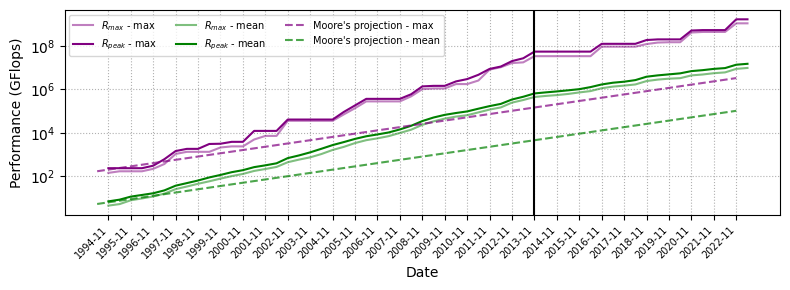

In [8]:
# Plotting : The maximum (and mean) Rmax Evolution of the Top500 supercomputers over time, along with Moore’s law projections
## plot settings
plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted') 
plt.yscale('log')

## mean & max df
log_df = concat_df.copy(deep=True)
log_df_mean = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').mean().reset_index()
log_df_max = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').max().reset_index()
log_df_mean['index'] = log_df_max.index + 1
log_df_max['index'] = log_df_mean.index + 1

## The mean and maximum plots of the Rmax value over time
sns.lineplot(data=log_df_max, x='index', y='RMax', label=r'$R_{max}$ - max', color='purple', alpha=0.5)
sns.lineplot(data=log_df_max, x='index', y='RPeak', label=r'$R_{peak}$ - max', color='purple')
sns.lineplot(data=log_df_mean, x='index', y='RMax', label=r'$R_{max}$ - mean', color='green', alpha=0.5)
sns.lineplot(data=log_df_mean, x='index', y='RPeak', label=r'$R_{peak}$ - mean', color='green')

## Curve fitting the maximum and mean Rmax values 
popt_max, _ = curve_fit(exp_funct, list(log_df_max['index'])[:40], list(log_df_max.RMax)[:40])
popt_mean, _ = curve_fit(exp_funct, list(log_df_mean['index'])[:40], list(log_df_mean.RMax)[:40])

## Plotting moore's projections 
plt.plot(
        [x for x in list(log_df_max.index)], [moore_funct(x, log_df_max) for x in list(log_df_max['index'])], 'g-', 
        label="Moore's projection - max".format(*popt_max), ls='dashed', color='purple', alpha=0.7
    )
plt.plot(
        [x for x in list(log_df_mean.index)], [moore_funct(x, log_df_mean) for x in list(log_df_mean['index'])], 'g-', 
        label="Moore's projection - mean".format(*popt_mean), ls='dashed', color='green', alpha=0.7
    )

plt.axvline(x = 39, color = 'black')

# Axis settings
plt.legend(ncol=3, loc=2,fontsize='7')
plt.xticks(
        rotation=45, ha='right', fontsize=7,ticks=np.arange(1, max(list(log_df_max['index'])), 2),
        labels=[list(log_df_max.rank_year)[i] for i in np.arange(1, max(list(log_df_max['index'])), 2)]
    )
plt.tight_layout()

plt.xlabel(r'Date')
plt.ylabel(r'Performance (GFlops)')

plt.savefig("fig2_v2.png", format="png", dpi=1200)

In [9]:
log_df.rank_year

0        1994-06
1        1994-06
2        1994-06
3        1994-06
4        1994-06
          ...   
28995    2022-11
28996    2022-11
28997    2022-11
28998    2022-11
28999    2022-11
Name: rank_year, Length: 29000, dtype: object

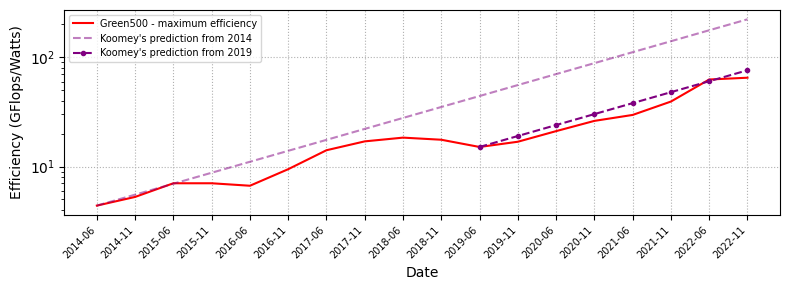

In [10]:

plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted') 

green_log_df = green_concat_df.copy(deep=True)
green_log_df_max = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max()

tmp = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max().reset_index()


sns.lineplot(data=green_log_df_max, x='rank_year', y='G_eff', label='Green500 - maximum efficiency', color='red')

plt.plot(list(tmp.rank_year), [koomey_funct(x, df=tmp, metric='G_eff') for x in list(tmp.index)], 'g-', 
         label="Koomey's prediction from 2014".format(*popt_max), ls='dashed', color='purple', alpha=0.5)
plt.plot(list(tmp.rank_year[10:]), [koomey_funct(x, df=tmp, y=10, metric='G_eff') for x in list(tmp.index)[10:]], 'g.-', 
         label="Koomey's prediction from 2019".format(*popt_max), ls='dashed', color='purple')


plt.yscale('log')
plt.xlabel(r'Date')
plt.ylabel(r'Efficiency (GFlops/Watts)')
plt.xticks(rotation=45, ha='right', fontsize=7)


ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=2.0))


plt.legend(ncol=1, loc=2, fontsize=7)
plt.tight_layout()

plt.savefig("fig3_v2.png", format="png", dpi=1200)


In [11]:
green_concat_df['Accelerator/Co-Processor'] = list(green_concat_df['Accelerator/Co-Processor'].notnull().astype('int'))
green_concat_df.head()

,Computer,Year,Country,Cores,Site,Power,RMax,RPeak,TOP500 Rank,Rank,Accelerator/Co-Processor,G_eff,rank_year,g_min_rank
0,"LX 1U-4GPU/104Re-1G Cluster, Intel Xeon E5-262...",2013,Japan,2720,"GSIC Center, Tokyo Institute of Technology",34.5800,151800.0,217824.0,437,1,1,4.389821,2014-06,437
1,"Dell T620 Cluster, Intel Xeon E5-2630v2 6C 2.6...",2013,United Kingdom,5120,Cambridge University,52.6176,191100.0,367565.0,201,2,1,3.631865,2014-06,201
2,"Cray 3623G4-SM Cluster, Intel Xeon E5-2680v2 1...",2013,Japan,4864,"Center for Computational Sciences, University ...",78.7700,277100.0,364288.0,165,3,1,3.517837,2014-06,165
3,"Bullx B515 cluster, Intel Xeon E5-2450v2 8C 2....",2014,Netherlands,3036,SURFsara,44.4000,153600.0,209880.0,421,4,1,3.459459,2014-06,421
4,"Cray XC30, Xeon E5-2670 8C 2.600GHz, Aries int...",2012,Switzerland,115984,Swiss National Supercomputing Centre (CSCS),1753.6600,5587000.0,7788852.8,6,5,1,3.185908,2014-06,6


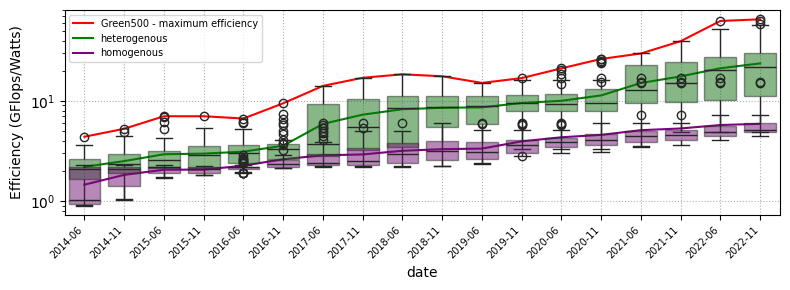

In [12]:
plt.figure(figsize=(8, 3))

g_gpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 1]
g_cpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 0]


sns.lineplot(data=green_concat_df.groupby('rank_year').max(), x='rank_year', y='G_eff', label='Green500 - maximum efficiency', color='red')
sns.lineplot(data=g_gpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', label='heterogenous', color='green')
sns.lineplot(data=g_cpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', label='homogenous', color='purple')

sns.boxplot(data=g_gpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', color='green',  boxprops=dict(alpha=.5))
sns.boxplot(data=g_cpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', color='purple',  boxprops=dict(alpha=.5))


plt.yscale('log')
plt.xlabel(r'date')
plt.ylabel(r'Efficiency (GFlops/Watts)')
plt.grid(linestyle='dotted') 
plt.legend(ncol=2, loc=9)


plt.xticks(rotation=45, ha='right', fontsize=7)


ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=2.0))


plt.legend(ncol=1, loc=2, fontsize=7)
plt.tight_layout()

plt.savefig("fig4_v2.png", format="png", dpi=1200)


In [13]:
carbon_df = pd.read_csv('./data/carbon_intensity_by_country.csv')
carbon_df[carbon_df['Entity'] == 'France']
carbon_df['Country'] = carbon_df['Entity']


In [14]:
n_concat_df = green_concat_df.copy(deep=True)
n_concat_df = n_concat_df.merge(carbon_df, on=['Year', 'Country'])

In [15]:
n_concat_df['electric_consumption (GWh)'] = n_concat_df['Power'] / 1e6
n_concat_df['Carbon footprint (TCO2)'] = n_concat_df['Carbon intensity of electricity - gCO2/kWh'] * n_concat_df['electric_consumption (GWh)']  # Kg co2 par GWh
n_concat_df['GFlops/KgCO2'] = n_concat_df['RMax'] / (n_concat_df['Carbon footprint (TCO2)'] * 1000)

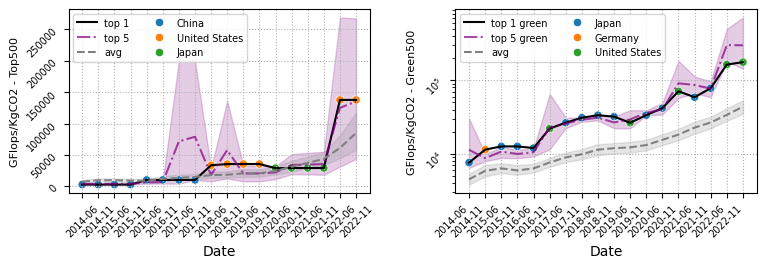

In [24]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
#plt.figure(figsize=(4, 3))
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 

plt.yscale('log')
plt.grid(linestyle='dotted')

## mean & max df
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] == 1]
log_df_5 = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]
log_df_mean = n_concat_df

g_log_df_max = n_concat_df[n_concat_df['Rank'] == 1]
g_log_df_5 = n_concat_df[n_concat_df['Rank'] <= 5]

## The top1 plots
sns.lineplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2', label='top 1', markers=True, color='black', ax=ax[0])
sns.lineplot(data=log_df_5, x='rank_year', y='GFlops/KgCO2', label='top 5', markers=True, color='purple', linestyle='-.', alpha=0.7, ax=ax[0])
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='avg', markers=True, color='grey', linestyle='--', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2',  markers=True, hue='Country', ax=ax[0])


sns.lineplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2', label='top 1 green', markers=True, color='black', ax=ax[1])
sns.lineplot(data=g_log_df_5, x='rank_year', y='GFlops/KgCO2', label='top 5 green', markers=True, color='purple', linestyle='-.', alpha=0.7, ax=ax[1])
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='avg', markers=True, color='grey', linestyle='--', ax=ax[1])
sns.scatterplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2',  markers=True, hue='Country', ax=ax[1])


## Layout
plt.legend(ncol=2, loc=9, fontsize="7")
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()

loc = plticker.MultipleLocator(base=1.0)

for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('GFlops/KgCO2 - Top500', fontsize='8')
ax[1].set_ylabel('GFlops/KgCO2 - Green500', fontsize='8')

figure.suptitle('', fontsize='9')
figure.subplots_adjust(top=0.88)
"""
## Axis settings
loc = plticker.MultipleLocator(base=4.0)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date')
ax.set_ylabel('GFlops/KgCO2')
"""
plt.savefig('fig8.png', format="png", dpi=1200)


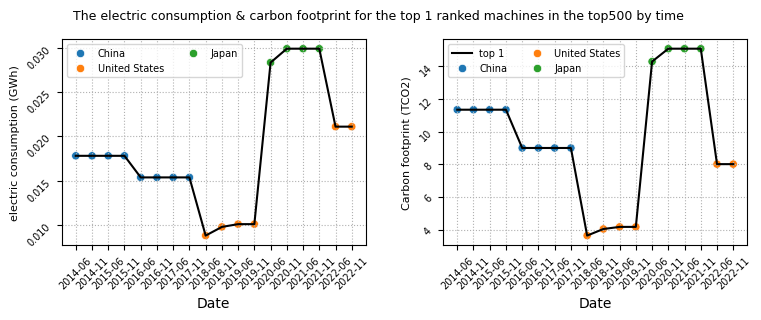

In [17]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] == 1]
log_df_mean = n_concat_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', label='top 1', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 1 ranked machines in the top500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('fig9')

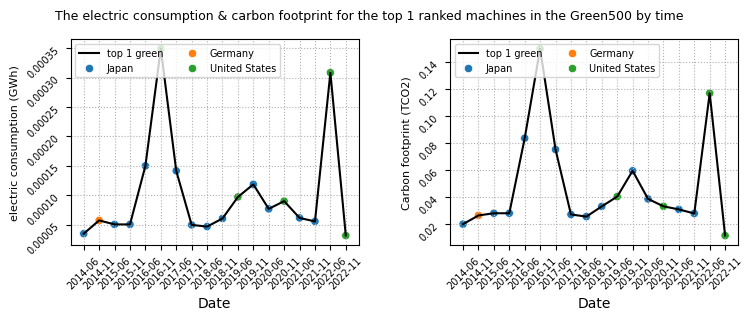

In [18]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = n_concat_df[n_concat_df['Rank'] == 1]
log_df_mean = n_concat_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top 1 green', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', label='top 1 green', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout


plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=2, loc=2, fontsize="7")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 1 ranked machines in the Green500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('green500_consumption.png')
plt.savefig('fig10')

In [29]:
ndf = n_concat_df[n_concat_df['Rank'] == 1]
ndf[ndf['rank_year'] == '2016-11']
# verifier les max 
# changer l y-axis du premier graph en echelle log

,Computer,Year,Country,Cores,Site,Power,RMax,RPeak,TOP500 Rank,Rank,Accelerator/Co-Processor,G_eff,rank_year,g_min_rank,Entity,Code,Carbon intensity of electricity - gCO2/kWh,electric_consumption (GWh),Carbon footprint (TCO2),GFlops/KgCO2
496,"NVIDIA DGX-1, Xeon E5-2698v4 20C 2.2GHz, Infin...",2016,United States,60512,NVIDIA Corporation,349.5,3307000.0,4896512.0,28,1,1,9.46209,2016-11,28,United States,USA,429.4371,0.000349,0.150088,22033.701089


In [27]:
ndf['rank_year']

0       2014-06
100     2014-11
199     2015-06
298     2015-11
397     2016-06
496     2016-11
596     2017-06
696     2017-11
796     2018-06
896     2018-11
996     2019-06
1096    2019-11
1196    2020-06
1296    2020-11
1396    2021-06
1496    2021-11
1596    2022-06
1696    2022-11
Name: rank_year, dtype: object

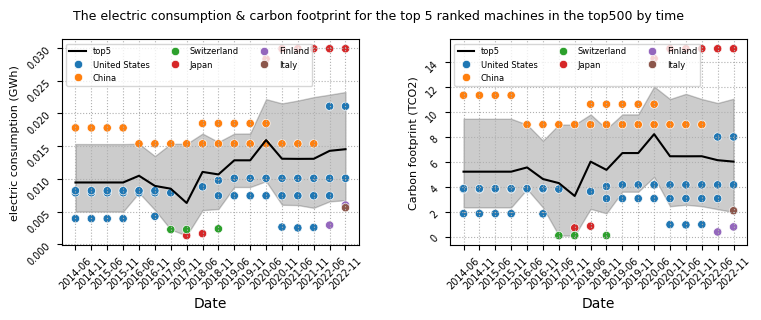

In [19]:
#sns.lineplot(data=new_df.groupby('rank_year').max(), x='rank_year', y='electric_consumption_y (GW)', label='overall maximum', color='red')
#sns.lineplot(data=new_df.groupby('rank_year').min(), x='rank_year', y='GFlops/KgCO2', label='overall maximum', color='red')

# Plotting : The evolution of the Top 1 [straight lines] supercomputer’s performance metrics (Rmax, Rpeak) compared to the average evolution of
# all the Top500 supercomputer [dashed lines] by date, based on the Top500 ranking list.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 
#plt.yscale('log')

## mean & max df
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]
log_df_mean = n_concat_df

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top5', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', label='top5', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Rmax-avg', markers=True, color='grey', linestyle='--')

## Layout
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=3, loc=2, fontsize="6")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 5 ranked machines in the top500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)
#sns.lineplot(data=log_df_max, x='rank_year', y='Power', label='Rmax-top 1', markers=True, color='grey')

## The mean plots
#sns.lineplot(data=log_df_mean, x='rank_year', y='Carbon footprint (TCO2)', label='avg', markers=True, color='grey', linestyle='--')
#sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country')
plt.savefig('fig9')

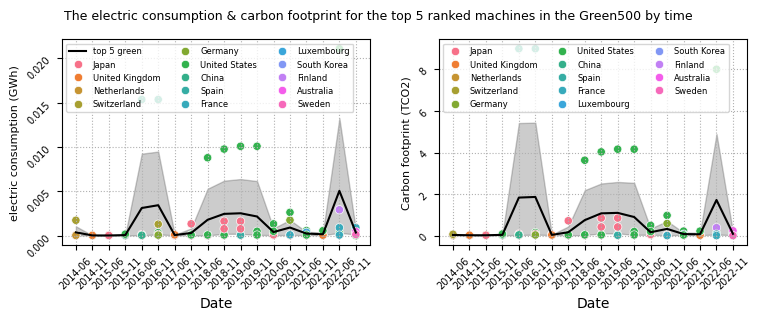

In [20]:
# Plotting : The electric consumption & carbon footprint for the top 5 ranked machines in the Green500 by time.
## plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3)) 

## top 5 df
log_df_max = n_concat_df[n_concat_df['Rank'] <= 5]

## The top1 plots
ax[0] = sns.lineplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)', label='top 5 green', markers=True, color='black', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='electric_consumption (GWh)',  markers=True, hue='Country', ax=ax[0])

sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)', markers=True, color='black', ax=ax[1])
sns.scatterplot(data=log_df_max, x='rank_year', y='Carbon footprint (TCO2)',  markers=True, hue='Country', ax=ax[1])

## Layout
plt.tight_layout()

## Axis settings
loc = plticker.MultipleLocator(base=1.0)
for i in [0, 1]:
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=3, loc=2, fontsize="6")
    
ax[0].set_ylabel('electric consumption (GWh)', fontsize='8')
ax[1].set_ylabel('Carbon footprint (TCO2)', fontsize='8')

figure.suptitle('The electric consumption & carbon footprint for the top 5 ranked machines in the Green500 by time', fontsize='9')
figure.subplots_adjust(top=0.88)

## figure save
#plt.savefig('.figures/green500_consumption.png')
